## Eye-tracking mit OpenCV

In [8]:
import cv2
import numpy as np

faceCascade = cv2.CascadeClassifier("./haarcascade/haarcascade_frontalface_default.xml")
eyeCascade = cv2.CascadeClassifier("./haarcascade/haarcascade_eye.xml")
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 1500
detector = cv2.SimpleBlobDetector_create(detector_params)
def search_eyes(img):
    # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = img.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale2(img_gray)
    face_size = 0
    biggest_face = None
    img_face = img_rgb.copy()
    try:
        if faces != None and type(faces[0][0] == int):
            for face in faces[0]:
                #find biggest one
                x, y, w, h = face
                if w*h > face_size:
                    face_size = w*h
                    biggest_face = face
            x, y, w, h = biggest_face
            img_face = cv2.rectangle(img_face, (x,y), (int(x+w//2), int(y+h//1.5)), (255,0,0),3)
            img_face = cv2.rectangle(img_face, (int(x+w//2),y), (x+w, int(y+h//1.5)), (255,0,0),3)
            gray_face = img_gray[y:int(y+h//2), x:x+w]
            face_pic = img_face[y:int(y+h//2), x:x+w]
            eyes = eyeCascade.detectMultiScale2(gray_face)
            try:
                if eyes != None:
                    for number, eye in enumerate(eyes[0]):
                        x, y, w, h = eye
                        face_pic = cv2.rectangle(face_pic, (x,y), (x+w, y+h), (0,255,0),3)
                        eye_center = (x+w//2, y+h//2)
                        face_pic = cv2.circle(face_pic, eye_center,5, (0,255,255), 3)
                        eye_gray = gray_face[y+h//4:y+h, x:x+w]
                        eye_thr = cv2.threshold(eye_gray, 50, 255, cv2.THRESH_BINARY)
            except:
                print("Eyes type: ", type(eyes))
                print(eyes)
        else:
            print("Else Zweig")
                        
    except:
        print("Faces type: ", type(faces))
        print(faces)
    return img_face, eyes

In [9]:
cap = cv2.VideoCapture(0)

while True:
    try:
        ret, frame = cap.read()
        img_face, _ = search_eyes(frame)
        cv2.imshow("frame", img_face)
        if cv2.waitKey(1) == ord("q"):
            break
    except:
        pass
cap.release()

Faces type:  <class 'tuple'>
((), ())
Faces type:  <class 'tuple'>
((), ())


## QR-Code Erkennung mittels Pyzbar

In [19]:
import cv2
from pyzbar.pyzbar import decode

In [30]:
qr1 = cv2.imread("IMG_4881.jpg")
detectedCodes = decode(qr1)
print(detectedCodes)
print("height, width, colours:",qr1.shape)

[Decoded(data=b'https://pracawpolsce.gov.pl/login', type='QRCODE', rect=Rect(left=1594, top=1369, width=194, height=212), polygon=[Point(x=1594, y=1568), Point(x=1787, y=1581), Point(x=1788, y=1384), Point(x=1596, y=1369)], quality=1, orientation='UP')]
height, width, colours: (4032, 3024, 3)


In [60]:
class QrCode():
    def __init__(self, data, angle_h, angle_v, area_p, image):
        self.data = data
        self.angle_h = angle_h
        self.angle_v = angle_v
        self.area_partial = area_p
        self.image = image
    
    def print_detail(self):
        print("Code Details:")
        print("data:", self.data)
        print("angle_h:", self.angle_h)
        print("angle_v", self.angle_v)
        print("area_partial", self.area_partial)
        

In [61]:
cv2.rectangle?

In [76]:
CAMERA_ANGLE = 90

def get_code_angles(img_width, img_height, qode_center):
    # bestimmen der Kamera-Winkel in Abhängigkeit von der Bildausrichtung
    if img_width > img_height:
        cam_angle_h = int(CAMERA_ANGLE)
        cam_angle_v = int(CAMERA_ANGLE/img_width*img_height) 
    else:
        cam_angle_h = int(CAMERA_ANGLE/img_height*img_width) 
        cam_angle_v = int(CAMERA_ANGLE)
    # Code-Position in Winkeln angeben
    # vertikal: oben = positiv
    # horizontal: rechts = positiv
    code_hor_pos, code_vert_pos = qode_center
    #horizontaler Winkel
    code_angle_h = (code_hor_pos - img_width//2)*cam_angle_h / img_width
    code_angle_v = (img_height//2 - code_vert_pos)*cam_angle_v/img_height # hier gedreht da oben 0 ist
    
    return (code_angle_h, code_angle_v)

def get_code_area_part(img_width, img_height, rect):
    img_area = img_height*img_width
    _, _, c_height, c_width = rect
    code_area = c_height * c_width
    return code_area/img_area
    
    
        
def get_center_from_rect(rect, img):
    left, top, height, width = rect
    center = (left+width//2, top+height//2)
    img_ret = cv2.rectangle(img, (left, top),(left+width, top+height), (0, 255, 0), 3 )
    return center, img_ret
    
    
    
def get_codes_from_img(qr_img):
    image_marked = qr_img.copy()
    found_codes = []
    img_h, img_w, num_colours = qr_img.shape
    detectedCodes = decode(qr_img)
    for code in detectedCodes:
        data = code.data.decode()
        rect_center, image_marked = get_center_from_rect(code.rect, image_marked)
        angle_h, angle_v = get_code_angles(img_w, img_h, rect_center)
        area_part = get_code_area_part(img_w, img_h, code.rect)
        qrCode = QrCode(data, angle_h, angle_v, area_part, image_marked)
        found_codes.append(qrCode)
        
    return found_codes
    


Code Details:
data: https://pracawpolsce.gov.pl/login
angle_h: 21.011904761904763
angle_v 12.886904761904763
area_partial 0.0008769132653061224
Code Details:
data: https://pracawpolsce.gov.pl/login
angle_h: 2.2023809523809526
angle_v -14.136904761904763
area_partial 0.0008687936980347695
Code Details:
data: https://pracawpolsce.gov.pl/login
angle_h: 3.5714285714285716
angle_v 8.779761904761905
area_partial 0.0008775693919543126
Code Details:
data: https://pracawpolsce.gov.pl/login
angle_h: 22.44047619047619
angle_v 37.79761904761905
area_partial 0.0008857709750566894
Code Details:
data: https://pracawpolsce.gov.pl/login
angle_h: -20.982142857142858
angle_v 39.43452380952381
area_partial 0.0008606741307634164


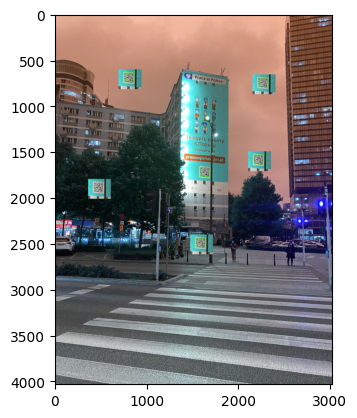

In [79]:
qr_img = cv2.imread("IMG_4880_6.jpg")
codes_in_pic = get_codes_from_img(qr_img)
qr_img = cv2.cvtColor(qr_img, cv2.COLOR_BGR2RGB)
    
for c in codes_in_pic:
    c.print_detail()
    plt.imshow(c.image)

## Voice commands mit vosk

In [2]:
import vosk

In [5]:

import argparse
import queue
import sys
import sounddevice as sd
import time
import pyttsx3

engine = pyttsx3.init()
engine.say("I will speak this text")
engine.runAndWait()

In [80]:

from vosk import Model, KaldiRecognizer
q = queue.Queue()
model = Model("vosk-model-small-de-0.15")

def int_or_str(text):
    """Helper function for argument parsing."""
    try:
        return int(text)
    except ValueError:
        return text

def callback(indata, frames, time, status):
    """This is called (from a separate thread) for each audio block."""
    if status:
        print(status, file=sys.stderr)
    q.put(bytes(indata))

def listenForInput():
    recText = None
    parser = argparse.ArgumentParser(add_help=False)
    parser.add_argument(
        "-l", "--list-devices", action="store_true",
        help="show list of audio devices and exit")
    args, remaining = parser.parse_known_args()
    if args.list_devices:
        print(sd.query_devices())
        parser.exit(0)
    parser = argparse.ArgumentParser(
        description=__doc__,
        formatter_class=argparse.RawDescriptionHelpFormatter,
        parents=[parser])
    parser.add_argument(
        "-f", "--filename", type=str, metavar="FILENAME",
        help="audio file to store recording to")
    parser.add_argument(
        "-d", "--device", type=int_or_str,
        help="input device (numeric ID or substring)")
    parser.add_argument(
        "-r", "--samplerate", type=int, help="sampling rate")
    args = parser.parse_args(remaining)

    try:
        if args.samplerate is None:
            device_info = sd.query_devices(args.device, "input")
            # soundfile expects an int, sounddevice provides a float:
            args.samplerate = int(device_info["default_samplerate"])

        #model = Model(lang="en-us")

        if args.filename:
            dump_fn = open(args.filename, "wb")
        else:
            dump_fn = None

        with sd.RawInputStream(samplerate=args.samplerate, blocksize = 8000, device=args.device,
                dtype="int16", channels=1, callback=callback):
            print("#" * 80)
            print("Press Ctrl+C to stop the recording")
            print("#" * 80)

            rec = KaldiRecognizer(model, args.samplerate)
            time_stopp = time.time()+ 5
            while True and time.time() < time_stopp:
                data = q.get()
                if rec.AcceptWaveform(data):
                    recText = rec.Result()
                    print(recText)
                    break
                else:
                    pass
                # print(rec.PartialResult())
                if dump_fn is not None:
                    dump_fn.write(data)

    except KeyboardInterrupt:
        print("\nDone")
        parser.exit(0)
    except Exception as e:
        parser.exit(type(e).__name__ + ": " + str(e))
    return recText

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from vosk-model-small-de-0.15/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from vosk-model-small-de-0.15/graph/HCLr.fst vosk-model-small-de-0.15/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:303) Loading winfo vosk-model-small-de-0.15/graph/phones/word_boundary.int


In [18]:
plainText = recText[14:-3]
engine.say(plainText)
engine.runAndWait()

In [88]:
_einer = {"null":0, "eins":1, "ein":1, "zwei":2, "drei":3, "vier":4, "fünf":5, "sechs":6, "sieben":7, "sieb":7, "acht":8, "neun":9, "elf":11, "zwölf":12,
          "zwanzig":20, "dreißig":30, "vierzig":40, "fünfzig":50, "sechzig":60, "siebzig":70, "achtzig":80, "neunzig":90,
          }
_zehner = {"zehn":10, "zwanzig":20, "dreißig":30, "vierzig":40, "fünfzig":50, "sechzig":60, "siebzig":70, "achtzig":80, "neunzig":90}

def get_einer(text):
    return  _einer.get(text, 0)

def get_zehner(text):
    return _zehner.get(text, 0)

def textToNumber(number_in_text:str):
    number = 0
    if "hundert" in number_in_text:
        hunderter, _, rest = number_in_text.partition("hundert")
        hunderter.strip()
        rest.strip()
        hdt = get_einer(hunderter)
        if(hdt > 0):
            number = hdt*100
        else:
            number = 100
        if "und" in rest:
            einer, _, zehner = rest.partition("und")
            number = number + get_einer(einer)+get_zehner(zehner)
        elif "zehn" in rest:
            number = number + get_einer(rest[:-4]) + 10
        else:
            number = number + get_einer(rest)   
    else:
        if "und" in number_in_text:
            einer, _, zehner = number_in_text.partition("und")
            number = get_einer(einer)+get_zehner(zehner)
        elif "zehn" in number_in_text:
            number = get_einer(number_in_text[:-4]) + 10
        else:
            number = get_einer(number_in_text)
    return number
        
        
        

In [94]:
engine.say("Wie alt bist du?")
engine.runAndWait()
age_text = listenForInput()
age = textToNumber(age_text[14:-3])
print("Alter:", age)

################################################################################
Press Ctrl+C to stop the recording
################################################################################
{
  "text" : "eins"
}
Alter: 1


## Datenbank mit sqlite3

In [102]:
import sqlite3

sql_con = sqlite3.connect("test.db")
sql_cur = sql_con.cursor()

In [103]:
data = sql_cur.execute("SELECT * from images")

In [106]:
def convertToBinary(filename):
    """takes a filename and returns the file in binary format

    Args:
        filename (_type_): full path

    Returns:
        _type_: data (binary)
    """
    with open(filename, "rb")as f:
        data = f.read()
    return data

In [107]:
def insertBlob(table, picture, title):
    try:
        sqlConnection = sqlite3.connect("test.db")
        cur = sqlConnection.cursor()
        sqlite_insert_blob_query = "INSERT INTO images(title, image) VALUES (?, ?)"
        image_bin = convertToBinary(picture)
        cur.execute(sqlite_insert_blob_query, title, image_bin)
        sqlConnection.commit()
    except:
        print("Error DB handling")
    finally:
        sqlConnection.close()

In [99]:
print(data)

In [100]:
type(data)

sqlite3.Cursor